# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 4. Матричный профиль. Поиск примитивов на его основе.**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Смена рабочей директории.

In [43]:
import os
os.chdir('/content/drive/MyDrive/2023-Sysoeva-TimeSeriesCourse/practice/04 Matrix profile')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Для выполнения данной практической работы используйте библиотеку *stumpy*, предназначенную для анализа временных рядов на основе матричного профиля.

Установите библиотеку *stumpy*.

In [45]:
!pip install stumpy

## **Часть 1.** Матричный профиль. Поиск мотивов и диссонансов.

Профиль Matrix имеет два основных компонента:

**профиль расстояния** - вектор минимальные Z-нормированные евклидовы расстояния

**индекс профиля** -содержит индекс его первого ближайшего соседа, другими словами, это местоположение его наиболее похожей подпоследовательности.

Алгоритмы, которые вычисляют профиль матрицы, используют раздвижное окно подходов с размером окнам.
Алгоритм:
1. Вычисляет расстояния для оконной подпоследовательности по всему временному ряду
2. Устанавливает зону исключения, чтобы игнорировать тривиальные совпадения
3. Обновляет профиль расстояния с минимальными значениями
4. Устанавливает первый индекс ближайшего соседа

Вычисления расстояния, изложенные выше, происходят n-м + 1 раз; где N длина временного ряда ,m это размер окна.

Поскольку подпоследовательности извлекаются из самого временного ряда,зона отчуждения требует, чтобы предотвратить тривиальные совпадения, Например, фрагмент, соответствующий самому себе, или фрагмент, расположенный очень близко к себе, считается тривиальным соответствием.

Зона отчуждения - это просто половина размера окна (м) как до, так и после текущего индекса окна. Значения этих индексов игнорируются при расчете минимального расстояния и индекса ближайшего соседа.

Импорт библиотек и модулей.

In [46]:
import pandas as pd
import numpy as np

from modules.plots import *
from modules.mp import *
from modules.motifs import *
from modules.discords import *

### **Задача 1.**
Загрузите временной ряд, который содержит данные о почасовом потреблении электроэнергии некоторого итальянского города, снимаемые в течение 3 лет, начиная с 1 января 1995 года.

In [47]:
ts_url = './datasets/part1/italianpowerdemand.csv'

ts = pd.read_csv(ts_url, header=None).squeeze().to_numpy()

Визуализируйте временной ряд, используя функцию `plot_ts()` из модуля *plot.py*.

In [48]:
plot_ts(ts, "Input time series")

Изучите [документацию](https://stumpy.readthedocs.io/en/latest/index.html) библиотеки *stumpy*. Напишите функцию `calculate_mp()` в модуле *mp.py*, которая вычисляет матричный профиль временного ряда на основе выбранной вами функции из библиотеки *stumpy*.

stumpy.stump(T_A, m, T_B=None, ignore_trivial=True, normalize=True, p=2.0, k=1, T_A_subseq_isconstant=None, T_B_subseq_isconstant=None)

Вычислите z-нормализованный матричный профиль

Это удобная оболочка вокруг скомпилированной Numba JIT параллельной функции _stump, которая вычисляет профиль матрицы (top-k) в соответствии с STOMPopt с корреляциями Пирсона.

In [49]:
m = 165
exclusion_zone = int(np.ceil(m / 2)) # ceil() из модуля math нужна для округления чисел с плавающей точкой в большую сторону
mp = {}

# INSERT YOUR CODE
# calculate_mp()  вычисляет матричный профиль временного ряда на основе выбранной функции из библиотеки stumpy.
#mp = stumpy.stump(ts1, m, ts2)
mp = compute_mp(ts, m, exclusion_zone)

Визуализируйте найденный матричный профиль временного ряда.

In [50]:
plot_ts(mp['mp'], "Matrix Profile")

### **Задача 2.**
Найдите top-$k$ мотивов во временном ряде на основе построенного матричного профиля.

**мотив** повторяется во временном ряду и **раздор** - это аномалия. С *вычисленным профилем матрицы* легко найти число мотивов или разногласий в топ-К. Матричный профиль хранит расстояния в евклидовом пространстве, что означает, что расстояние, близкое к 0, наиболее похоже на другую подпоследовательность во временном ряду, а расстояние, удаленное от 0, скажем, 100, отличается от любой другой подпоследовательности. **Извлечение самых низких расстояний дает мотивы, а самые большие расстояния дает диссонанс.**

In [51]:
top_k = 6
motifs = {}

 # np.argsort() возвращает индексы элементов в отсортированном порядке, а оператор - используется для сортировки
top_k_idxs = np.argsort(mp['mp'])[:top_k]

motifs['indices'] = [sorted([idx, mp['mpi'][idx]]) for idx in top_k_idxs]



In [52]:
#!!!
motifs['indices'] #мотив (справа и слева)

[[17852, 18188],
 [17852, 18188],
 [17853, 18189],
 [17853, 18189],
 [17858, 18194],
 [17858, 18194]]

**stumpy.motifs**(T, P, min_neighbors=1, max_distance=None, cutoff=None, max_matches=10, max_motifs=1, atol=1e-08, normalize=True, p=2.0, T_subseq_isconstant=None)

Находим главные мотивы временного ряда T

Подпоследовательность Q становится мотивом-кандидатом, если существует по крайней мере min_neighbor количество других совпадений подпоследовательности в T (вне зоны исключения) с расстоянием, меньшим или равным max_distance.

T (numpy.ndarray) – временной ряд или последовательность

P (numpy.ndarray) — (1-мерный) матричный профиль T. В случае, когда матричный профиль был вычислен с k > 1 (т. е. top-k ближайших соседей), вы должны суммировать top-k ближайших соседей. расстояния до соседей для каждой подпоследовательности в одно значение (например, np.mean, np.min и т. д.), а затем используйте это полученное значение в качестве P.


In [57]:
#!!!
top_k = 6
motifs = {}

top_k_idxs = stumpy.motifs(ts.astype(np.float64), mp['mp'], max_matches=top_k)[1][0]

motifs['indices'] = [sorted([top_k_idxs[i], top_k_idxs[i+1]]) for i in range(0, len(top_k_idxs)-1, 2)]

In [58]:
#!!!
motifs['indices']


[[17852, 18188], [26757, 26925], [9115, 18020]]

Выполните визуализацию найденных top-$k$ мотивов.

In [59]:
plot_motifs(mp, motifs)

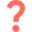
Проанализируйте и изложите содержательный смысл полученных результатов.

*# WRITE YOUR ANSWER*

### **Задача 3.**
Найдите top-$k$ диссонансов во временном ряде на основе матричного профиля.

Для решения данной задачи загрузите временной ряд, содежащий данные о среднем числе пассажиров NY такси за осень 2014 года.

In [60]:
ts_url = './datasets/part1/nyc_taxi.csv'

ts = pd.read_csv(ts_url, index_col=0, header=0).squeeze().to_numpy()

In [61]:
plot_ts(ts, "Input time series")

Найдите матричный профиль и на его основе top-$k$ диссонансы.

In [62]:
m = 96
exclusion_zone = int(np.ceil(m / 2))

mp = {}

# INSERT YOUR CODE
mp = compute_mp(ts.astype(np.float64), m, exclusion_zone)
np.array([])
np.argsort(mp['mp'])

array([2636, 2300, 2662, ..., 9984, 9986, 9985])

In [64]:
top_k = 15
discords = {}

# INSERT YOUR CODE
top_k_idxs = []
argsort_mp = np.argsort(mp['mp'])
for i in range (1, len(argsort_mp)+1):
  idx = argsort_mp[-i]
  flag =True
  for top_k_idx in top_k_idxs:
      if abs (top_k_idx - idx) < exclusion_zone:
        flag = False
  if flag:
      top_k_idxs.append(idx)
  if len (top_k_idxs) == top_k:
      break
print(top_k_idxs)



[9985, 10048, 8784, 10097, 8837, 5868, 105, 9651, 8449, 5954, 7107, 154, 8396, 8640, 2930]


In [65]:
#!!!
discords['indices'] = top_k_idxs

In [ ]:
discords['indices']

[9985,
 10048,
 8784,
 10097,
 8837,
 5868,
 105,
 9651,
 8449,
 5954,
 7107,
 154,
 8396,
 8640,
 2930]

Выполните визуализацию найденных top-$k$ диссонансов.

In [66]:
plot_discords(mp, discords)

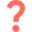
Проанализируйте и изложите содержательный смысл полученных результатов.

*# WRITE YOUR ANSWER*

## **Часть 2.** Сегментация повторяющихся активностей.

### **Задача 4.**

Загрузите временной ряд PAMAP, представляющий собой показания закрепленного на человеке виброакселерометра. Данный ряд включает показания при трех видах физической активности: ходьба, подъем по лестнице, спуск по лестнице.

In [ ]:
ts_url = './datasets/part2/pamap.csv'

ts = pd.read_csv(ts_url, header=None).squeeze().to_numpy()

Визуализируйте временной ряд PAMAP.

In [ ]:
plot_ts(ts, "Input time series")

Найдите и визуализируйте матричный профиль временного ряда.

In [ ]:
m = 100
exclusion_zone = m
mp = {}

# INSERT YOUR CODE

In [ ]:
plot_ts(mp['mp'], "Matrix Profile")

Вычислите порог по формуле, которая представлена в презентации [04 Matrix profile.pdf](https://github.com/mzym/TimeSeriesCourse/blob/main/slides/04%20Matrix%20profile.pdf).

In [ ]:
threshold = 0

# INSERT YOUR CODE

Выполните визуализацию результатов сегментации повторяющихся активностей.

In [ ]:
plot_segmentation(mp, threshold)

Загрузите истинную разметку временного ряда PAMAP, где 0 – ходьба, 1 – подъем по лестнице, 2 – спуск с лестницы. Вычислите точность по метрике accuracy, сравнив полученные результаты по основе матричного профиля с истинной разметкой.

In [ ]:
labels_url = './datasets/part2/pamap_labels.csv'

labels = pd.read_csv(labels_url, header=None).squeeze().to_numpy()

In [ ]:
# INSERT YOUR CODE

## **Чaсть 3.** Casy Study: Раскрытие краж электричества подменой счетчиков (meter-swapping detection).


### **Задача 5.**

Рассмотрим практическое применение использования матричного профиля для решения задачи, связанной с раскрытием краж электричества путем подмены счетчиков.

Загрузите временные ряды из директории *./datasets/part3/*, которые были выбраны случайным образом из набора данных (House 1, 2, 3, 4 и 11), содержащего данные потребления электроэнергии 20 жилых домов в Великобритании с 1 января по 23 декабря 2013 года.

In [ ]:
import os
import datetime

from modules.meter_swapping_detection import *

In [ ]:
path = './datasets/part3/'

house_idx = [1, 2, 3, 4, 11]

filenames = [f"House{i}.csv" for i in house_idx]

consumptions = {}
for house in filenames:
    consumptions[house[:-4]] = pd.read_csv(os.path.join(path, house), header=None, index_col=0)
    consumptions[house[:-4]].index = pd.to_datetime(consumptions[house[:-4]].index, dayfirst=True)

Далее смоделируем событие замены счетчика. Для этого каждый временной ряд разделим на две части: "Head" (до 10 октября) и "Tail" (после 10 октября). После чего выберем случайным образом 2 временных ряда (например, House1 и House11) и поменяем местами их "Tail" части.

In [ ]:
cutoff = pd.to_datetime('2014-10-01')
heads, tails = heads_tails(consumptions, cutoff, house_idx)

#swap Heads and Tails of 1 and 11
swap1, swap2 = 1, 11
consumptions[f'House{swap1}'] = heads[f'H_{swap1}'].append(tails[f'T_{swap2}'])
consumptions[f'House{swap2}'] = heads[f'H_{swap2}'].append(tails[f'T_{swap1}'])
heads, tails = heads_tails(consumptions, cutoff, house_idx)

Визуализируйте исходные временные ряды и параллельную оси OY прямую, которая делит временные ряды на "Head" и "Tail" части.

In [ ]:
plot_consumptions_ts(consumptions, cutoff, house_idx)

Чтобы найти переставленную пару временных рядов, выполним следующее. Сначала составим временные ряды $H_i$ из всевозможных комбинаций "Head" и "Tail" частей исходных временных рядов $T_K$, где $1 \leq i \leq |T|^2$, $1 \leq K \leq |T|$. В нашем случае, $|T| = 5$.  Далее среди них найдем такую пару временных рядов $(H_i, H_j)$, которая имеет минимальную оценку $swap\_score$. Минимальная оценка $swap\_score$ для пары рядов $(H_i, H_j)$ вычисляется следующим образом:

\begin{equation}
swap\_score(i,j) = \frac{\min{(Head_{H_i} \bowtie Tail_{H_j})}}{\min{(Head_{H_i} \bowtie Tail_{H_i})}+eps},
\end{equation}

где $\bowtie$ – операция нахождения матричного профиля между двумя временными рядами. Матричный профиль между двумя временными рядами содержит расстояния между всеми подпоследовательностями первого временного ряда и их ближайшими соседями, которые являются подпоследовательностями второго временного ряда.

Добавьте в функцию `compute_mp()` в модуле *mp.py* поддежку вычисления матричного профиля между двумя различными временными рядами и найдите пару временных рядов $(H_i, H_j)$, которая имеет минимальную оценку $swap\_score$ среди всех пар.

In [ ]:
m = 24 * 4

min_score = meter_swapping_detection(heads, tails, house_idx, m)

In [ ]:
min_i, min_j, mp_j = min_score['i'], min_score['j'], min_score['mp_j']
print(f'Time series with minimum score is (H_{min_i}, T_{min_j}).')

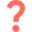
Проанализируйте и изложите содержательный смысл полученных результатов.

*# WRITE YOUR ANSWER*